In [1]:
import xarray as xr
import healpy as hp
import easygems.healpix as egh
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cf
import cmocean

In [2]:
zoom = 5
zoom = 6
nside = 2**zoom
Np = hp.nside2npix(nside)
res = 1/np.sqrt(Np/360/180)
print('effective res is ~' + str(res) + ' degrees')

effective res is ~1.1481983169296146 degrees


In [3]:
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + str(zoom) + '.zarr/' 
#file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT1H.z' + str(zoom) + '.zarr'
ds2d = xr.open_zarr(file)
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT3H.z' + str(zoom) + '.zarr/' 
#file = '/scratch/nf33/Healpix_data/UM/data.healpix.PT3H.z' + str(zoom) + '.zarr'
ds3d = xr.open_zarr(file)

In [4]:
#...variables used for IDing
time2 = ds2d['time']
time3 = ds3d['time']
Nt = len(time3)
psl = ds2d['psl'].sel(time=time3)
dzg = ds3d['zg'].sel(pressure=300) - ds3d['zg'].sel(pressure=500)
wa3 = ds3d['wa'].sel(pressure=300)

In [5]:
#...algorithm doesn't like the xarrays
p0 = np.asarray(psl)
zd = np.asarray(dzg)
wa = np.asarray(wa3)
Nt,Np = np.shape(p0)

In [6]:
#...find all local psl minima (first pass)
#   could apply a land mask here too
step = 1024
icy = np.zeros((Nt,Np))
for n in np.arange(Np,step=step):
 ip  = np.arange(step)+n
 ips = np.ravel(hp.get_all_neighbours(nside,ip,nest=True).T)
 ip0 = np.repeat(ip,8)
 icy[:,ip] = np.min(np.reshape(p0[:,ips]-p0[:,ip0],shape=(Nt,step,8)),axis=2)>0

In [7]:
#...apply msl criteria and whatever other filters (second pass)
psl_rad = 5.5
zgp_rad = 6.5
wa3_rad = 3
for ip in np.arange(Np):
 its = np.nonzero(icy[:,ip])[0]
 if(len(its)):
  vec = hp.pix2vec(nside,ipix=ip,nest=True)
  ipp = hp.query_disc(nside, vec, radius=np.radians(psl_rad),nest=True)
  ipw = hp.query_disc(nside, vec, radius=np.radians(wa3_rad),nest=True)
  #...this code is to define a ring of points, rather than a disc
  #ipz = np.setdiff1d(hp.query_disc(nside, vec, radius=np.radians(zgp_rad  ),nest=True),
  #                    hp.query_disc(nside, vec, radius=np.radians(zgp_rad/2),nest=True))
  for it in its:
   icy[it,ip] = ( icy[it,ip]
                * ((np.max(p0[it,ipp])-p0[it,ip])>200)    #...pressure criteria 
                * ( np.max(wa[it,ipw])           >0.2)    #...arbitrary w criteria
#                * ((zd[it,ip]-np.mean(zd[it,ipz]))>6)    #...the warm core criteria (not working?!)
                )

In [8]:
#...for reference, from tempestExtremes...
#
#(a) msl,200.0,5.5,0 represents that mean sea level pressure must increase by 200 Pa 
#over a 5.5 great circle distance (GCD) from the detected node;
#(b) _DIFF(z(300millibars),z(500millibars)),-58.8,6.5,1.0 represents that the difference between geopotential (Z)
#on the 300 and 500 millibars surfaces must decrease by 58.8 m2 s−2 over a 6.5
#GCD, using the maximum value of this field within 1 GCD as reference. This ensures a coherent upper-level warm
#core attached to the detected surface low

<Figure size 640x480 with 0 Axes>

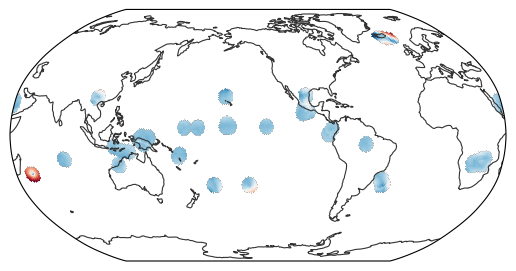

In [9]:
#...check if looks correct
m = np.zeros(Np)*np.nan
n = 100
for ip in np.nonzero(icy[n,:])[0]:
 vec = hp.pix2vec(nside,ipix=ip,nest=True)
 ips = hp.query_disc(nside, vec, radius=np.radians(5), nest=True)
 m[ips] = ds2d['psl'].sel(time=time3[n],cell=ips)-ds2d['psl'].sel(time=time3[n],cell=ip)
egh.healpix_show(m, cmap = 'RdBu_r')

/jobfs/141338845.gadi-pbs/ipykernel_2450616/2481074274.py:5: RuntimeWarning: divide by zero encountered in log
  m = np.log(np.sum(icy,axis=0))


<Figure size 640x480 with 0 Axes>

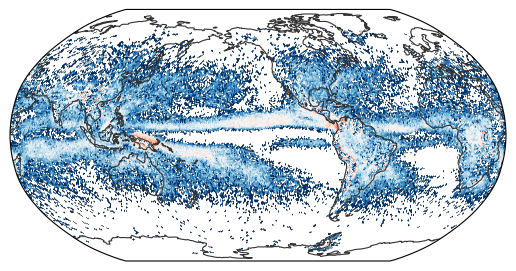

In [10]:
#...check if it looks reasonable
m = psl[0,:]*np.nan
for n in np.arange(240):
 m[icy[n,:]==1]=n+1
m = np.log(np.sum(icy,axis=0))
egh.healpix_show(m, cmap = 'RdBu_r')
#hp.mollview(m, title=str(n),nest=True)

In [11]:
#...tracking, step 1
#   for each cyclone, find the closest at the next time
rad_max = 3    #...max search radius in degrees
icy_next = np.zeros((Nt,Np),dtype=int)-1
ips0 = np.nonzero(icy[0,:])[0]
icy_next[0,ips0] = ips0
for it in np.arange(Nt-1):
 ips1 = np.nonzero(icy[it+1,:])[0]
 for ip0 in ips0:
  #...first check for immediate neighbours (cheap)
  ips = hp.get_all_neighbours(nside,ip0,nest=True)
  ip1 = np.intersect1d(ips,ips1)
  if(len(ip1)>0):
   icy_next[it+1,ip0] = ip1[0]    #...if more than one, arbitrarily pick the first
  else:
   #...otherwise use an increasing search radius (of effective res for this zoom)
   rad = res
   vec = hp.pix2vec(nside,ipix=ip0, nest=True)
   while(rad<=rad_max):   
    ips = hp.query_disc(nside, vec, radius=np.radians(rad), nest=True)
    ip1 = np.intersect1d(ips,ips1)
    rad = rad+res
    if(len(ip1)>0):
     icy_next[it+1,ip0] = ip1[0]     #...if more than one, arbitrarily pick the first
 ips0 = ips1

In [12]:
#...tracking, step 2  (may combine overlapping events that start from same location??) 

#   join them up, working backwards
tracks = np.array(icy_next,dtype=int)
for it in np.arange(Nt-1,0,step=-1):
 ips = np.nonzero(tracks[it,:]>=0)[0]
 if(len(ips)):
  for ip in ips:
   tracks[np.arange(it+1,Nt),ip] = tracks[np.arange(it+1,Nt),tracks[it,ip]]

#   then split into discrete events
tk = np.ravel(tracks.T)
a = np.diff(np.asarray(-1==tk,dtype=float))
i0 = np.nonzero(a<0)[0]+1
i1 = np.nonzero(a>0)[0]+1
ii = np.ravel(np.reshape(np.concatenate((i0,i1)),shape=(2,len(i0))).T)
tracks = np.split(tk,ii)

#...start times of each event
#itimes = np.remainder(i0,Nt)
#ttimes = time3[itimes]
ti = np.ravel(np.reshape(np.repeat(np.arange(Nt),Np),(Nt,Np)).T)
itimes = np.split(ti,ii)
#ti = np.ravel(np.reshape(np.repeat(time3,Np),(Nt,Np)).T)
#ttimes = np.split(ti,ii)

#   housekeeping
Ntr=np.floor(len(i0)/2).astype(int)
tracks = tracks[slice(1,2*Ntr,2)]
itimes = itimes[slice(1,2*Ntr,2)]
#ttimes = ttimes[slice(1,2*Ntr,2)]
#itimes = itimes[np.arange(1,2*Ntr,step=2)]
#ttimes = ttimes.isel(time=np.arange(1,2*Ntr,step=2))

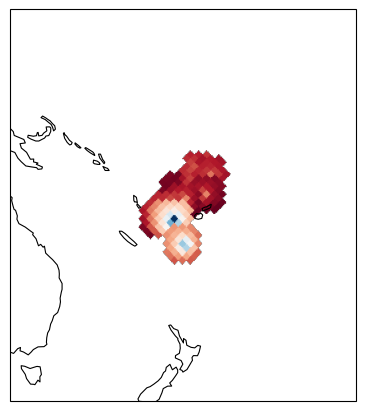

In [13]:
#...check if it looks right (the longest event here)
lens = np.arange(Ntr-1)
for n in np.arange(Ntr-1):
 lens[n] = len(tracks[n])
ic = np.argmax(lens)
ln,lt = hp.pix2ang(nside, tracks[ic], nest=True, lonlat=True)

m = np.zeros(Np)*np.nan
for n in np.arange(len(tracks[ic]),step=8):
#for n in np.arange(1):
 vec = hp.pix2vec(nside,ipix=tracks[ic][n],nest=True)
 ips = hp.query_disc(nside, vec, radius=np.radians(3), nest=True)
 m[ips] = ds2d['psl'].sel(time=time3[itimes[ic][n]],cell=ips)

projection = ccrs.Robinson(central_longitude=np.mean(ln))
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([np.mean(ln)-30, np.mean(ln)+30, np.mean(lt)-30, np.mean(lt)+30], crs=ccrs.PlateCarree())
egh.healpix_show(m, ax=ax,cmap = 'RdBu_r')
ax.add_feature(cf.COASTLINE, linewidth=0.8)

In [14]:
#...plot this rack at high res
zoom_hi= 10
nside_hi = 2**zoom_hi
Np_hi = hp.nside2npix(nside_hi)
print('effective res is ~' + str(1/np.sqrt(Np_hi/360/180)) + ' degrees')
file = '/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z' + str(zoom_hi) + '.zarr/' 
ds2d_hi = xr.open_zarr(file)

effective res is ~0.07176239480810091 degrees


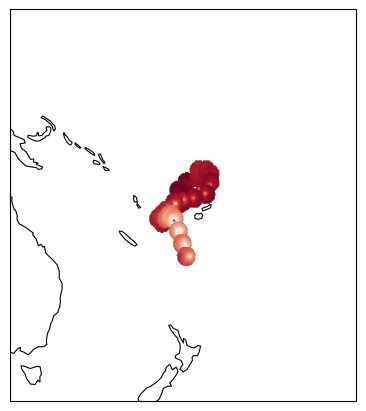

In [15]:
lens = np.arange(Ntr-1)
for n in np.arange(Ntr-1):
 lens[n] = len(tracks[n])
ic = np.argmax(lens)
ln,lt = hp.pix2ang(nside, tracks[ic], nest=True, lonlat=True)

m = np.zeros(Np_hi)*np.nan
for n in np.arange(len(tracks[ic]),step=4):
 vec = hp.pix2vec(nside,ipix=tracks[ic][n],nest=True)
 ips = hp.query_disc(nside_hi, vec, radius=np.radians(1.5), nest=True)
 m[ips] = ds2d_hi['psl'].sel(time=time3[itimes[ic][n]],cell=ips)

projection = ccrs.Robinson(central_longitude=np.mean(ln))
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([np.mean(ln)-30, np.mean(ln)+30, np.mean(lt)-30, np.mean(lt)+30], crs=ccrs.PlateCarree())
egh.healpix_show(m, ax=ax,cmap = 'RdBu_r')
ax.add_feature(cf.COASTLINE, linewidth=0.8)

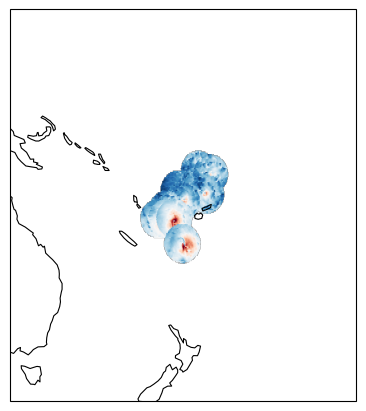

In [16]:
lens = np.arange(Ntr-1)
for n in np.arange(Ntr-1):
 lens[n] = len(tracks[n])
ic = np.argmax(lens)
ln,lt = hp.pix2ang(nside, tracks[ic], nest=True, lonlat=True)

m = np.zeros(Np_hi)*np.nan
for n in np.arange(len(tracks[ic]),step=8):
 vec = hp.pix2vec(nside,ipix=tracks[ic][n],nest=True)
 ips = hp.query_disc(nside_hi, vec, radius=np.radians(3), nest=True)
 m[ips] = np.sqrt( ds2d_hi['uas'].sel(time=time3[itimes[ic][n]],cell=ips)**2
                 + ds2d_hi['vas'].sel(time=time3[itimes[ic][n]],cell=ips)**2
                 )
projection = ccrs.Robinson(central_longitude=np.mean(ln))
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([np.mean(ln)-30, np.mean(ln)+30, np.mean(lt)-30, np.mean(lt)+30], crs=ccrs.PlateCarree())
egh.healpix_show(m, ax=ax,cmap = 'RdBu_r',vmax=30)
ax.add_feature(cf.COASTLINE, linewidth=0.8)

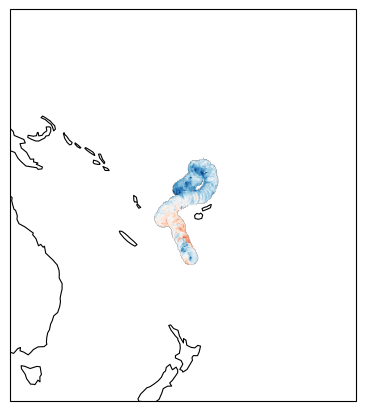

In [18]:
#...to adjust the track using the hi res data
m = np.zeros(Np_hi)*np.nan
for n in np.arange(len(tracks[ic]),step=8):
 vec = hp.pix2vec(nside,ipix=tracks[ic][n],nest=True)
 ips = hp.query_disc(nside_hi, vec, radius=np.radians(res), nest=True)
 ip = ips[np.argmin(np.asarray(ds2d_hi['psl'].sel(time=time3[itimes[ic][n]],cell=ips)))]
 vec = hp.pix2vec(nside_hi,ipix=ip,nest=True)
 ips = hp.query_disc(nside_hi, vec, radius=np.radians(3), nest=True)
 m[ips] = np.sqrt( ds2d_hi['uas'].sel(time=time3[itimes[ic][n]],cell=ips)**2
                 + ds2d_hi['vas'].sel(time=time3[itimes[ic][n]],cell=ips)**2
                 )

projection = ccrs.Robinson(central_longitude=np.mean(ln))
fig, ax = plt.subplots(
    figsize=(8, 4), subplot_kw={"projection": projection}, constrained_layout=True
)
ax.set_extent([np.mean(ln)-30, np.mean(ln)+30, np.mean(lt)-30, np.mean(lt)+30], crs=ccrs.PlateCarree())
egh.healpix_show(m, ax=ax,cmap = 'RdBu_r',vmax=30)
ax.add_feature(cf.COASTLINE, linewidth=0.8)

In [59]:
#...to adjust the track using the hi res data

for n in np.arange(len(tracks[ic])):
  vec = hp.pix2vec(nside,ipix=tracks[ic][n],nest=True)
  ips = hp.query_disc(nside_hi, vec, radius=np.radians(res), nest=True)
   = np.argmin(np.asarray(ds2d_hi['psl'].sel(time=time3[itimes[ic][n]],cell=ips)))

KeyboardInterrupt: 